# Sync

In [1]:
!aws s3 sync resources/grn-benchmark s3://openproblems-data/resources/grn/grn-benchmark --delete
!aws s3 sync resources/grn_models/ s3://openproblems-data/resources/grn/grn_models --delete
!aws s3 sync resources/prior/ s3://openproblems-data/resources/grn/prior --delete
!aws s3 sync resources/results/ s3://openproblems-data/resources/grn/results --delete

upload: resources/prior/skeleton_promotor.csv to s3://openproblems-data/resources/grn/prior/skeleton_promotor.csv
upload: resources/prior/skeleton.csv to s3://openproblems-data/resources/grn/prior/skeleton.csv
upload: resources/results/robustness_analysis/net-50-scores.csv to s3://openproblems-data/resources/grn/results/robustness_analysis/net-50-scores.csv
upload: resources/results/robustness_analysis/sign-50-scores.csv to s3://openproblems-data/resources/grn/results/robustness_analysis/sign-50-scores.csv
upload: resources/results/robustness_analysis/tmp/grnboost2.csv to s3://openproblems-data/resources/grn/results/robustness_analysis/tmp/grnboost2.csv
upload: resources/results/robustness_analysis/tmp/ppcor.csv to s3://openproblems-data/resources/grn/results/robustness_analysis/tmp/ppcor.csv
upload: resources/results/robustness_analysis/tmp/positive_control.csv to s3://openproblems-data/resources/grn/results/robustness_analysis/tmp/positive_control.csv
upload: resources/results/robust

In [33]:
!aws s3 sync resources_test/ s3://openproblems-data/resources_test/grn/ --delete

# Import

In [1]:
%reload_ext autoreload
%autoreload 2
import yaml
import os
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
from src.exp_analysis.helper import plot_cumulative_density
import matplotlib.pyplot as plt
import sys 
import subprocess
import io
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../')
from grn_benchmark.src.helper import surragate_names
from src.helper import *
par = {
    # 'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'genie3', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'scenicplus'],
    'models_dir': 'resources/grn_models/',
    'scores_dir': 'resources/scores'
}

# Prior 

In [2]:
if False: 
    create_skeleton() # create tf2gene putative links

# Run grn inference 

In [31]:
if True: # local runs
    run_grn_inference()

portia
Job portia submitted successfully.
Submitted batch job 7824332

grnboost2
Job grnboost2 submitted successfully.
Submitted batch job 7824333

ppcor
Job ppcor submitted successfully.
Submitted batch job 7824334

scenic
Job scenic submitted successfully.
Submitted batch job 7824335



# Calculate scores

In [47]:
if False: # consensus: run this after updating grns
    run_consensus(par)

if True: # run metrics/script_all.py
    calculate_scores()

Submitted batch job 7761215


In [13]:
df_scores = pd.read_csv(f"resources/results/op/scores/50000-skeleton_False-binarize_True_pearson-ridge.csv", index_col=0)
df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
collectri,0.000000,0.000000,0.259349,0.315582,0.280466,11
negative_control,0.000000,0.000000,0.217135,0.299650,0.280869,12
positive_control,0.364502,0.559577,0.649432,0.479137,0.301135,2
pearson_corr,0.265268,0.454829,0.586512,0.451191,0.294040,4
portia,0.202255,0.294004,0.509898,0.371612,0.288194,7
ppcor,0.000000,0.000000,0.362309,0.335297,0.281065,10
grnboost2,0.336660,0.412794,0.618150,0.529452,0.322410,1
scenic,0.136290,0.191758,0.559705,0.457482,0.309582,6
granie,0.072278,0.093852,0.173809,0.257547,0.270805,13
scglue,0.061218,0.256443,0.512147,0.340961,0.283731,8


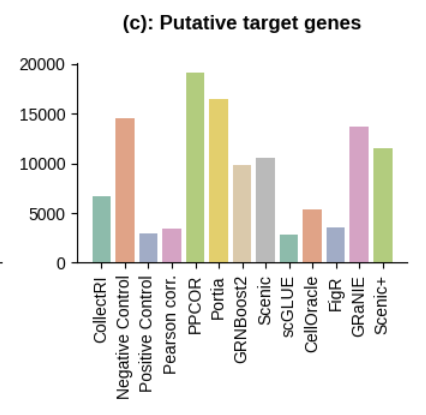

In [10]:
df_scores = pd.read_csv(f"output/temp/replogle2/50000-skeleton_False-binarize_True_X-ridge.csv", index_col=0)
df_scores[df_scores<0] = 0

df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
negative_control,0.000000,0.000000,0.004070,0.007549,7
positive_control,0.000000,0.434921,0.070334,0.051472,2
pearson_corr,0.000000,0.423552,0.068009,0.049308,3
portia,0.000000,0.478517,0.052368,0.043075,4
ppcor,0.000000,0.000000,0.007153,0.009689,6
grnboost2,0.000000,0.555928,0.083347,0.067546,1
scenic,0.000000,0.256618,0.031547,0.021333,5


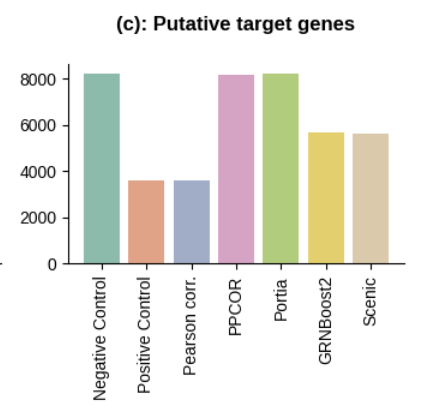

In [20]:
df_scores = pd.read_csv(f"output/temp/nakatake/50000-skeleton_False-binarize_True_X-ridge.csv", index_col=0)
df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
negative_control,0.000000,0.000000,0.002804,0.029785,5
positive_control,0.000000,0.561853,0.180887,0.216097,1
pearson_corr,0.000000,0.564298,0.147750,0.162404,2
portia,0.151603,0.043896,0.072315,0.056640,4
grnboost2,0.000000,0.357502,0.108230,0.159036,3


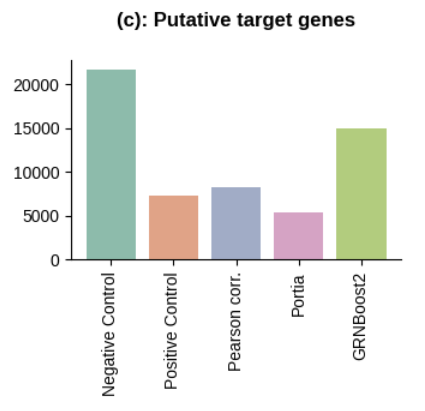

In [2]:
!ls output/temp/

nakatake  op  replogle2


In [19]:
df_scores = pd.read_csv(f"output/temp/nakatake/10000-skeleton_False-binarize_False_X-ridge.csv", index_col=0)
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
negative_control,-0.024738,-0.056955,0.025719,0.045412,3
positive_control,0.002988,0.649137,0.122582,0.092433,1
pearson_corr,0.028859,0.532826,0.071062,0.072747,2


In [ ]:
df_scores = pd.read_csv(f"resources/scores/50000-skeleton_True-binarize_True_pearson-ridge.csv", index_col=0)
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

# Format resourcs used

In [20]:
if True: 
    # job_ids_dict_hvg = { 
    #     'portia': 7744548,
    #     'grnboost2': 7742249,
    #     'scenic': 7742283,
    #     'genie3': 7742285,
    #     'ppcor': 7742364,
    #     'scglue': 7742343,
    # }

    job_ids_dict = { 
        'portia': 7751292,
        'grnboost2': 7747906,
        'scenic': 7748219,
        'ppcor': 7748321,
        'scglue': [7756286, 7756675],
        'scenicplus': [7761874, 7760439, 7760554],
        'figr': 7756664,
        'celloracle': 7761872,
        'pearson_corr': 7770044,
        'positive_control': 7770047,
        'negative_control':7770048 
    }
    
    df_res = process_trace_local(job_ids_dict)
    df_res = df_res[['Elapsed', 'MaxVMSize']]
    granie = pd.DataFrame({'Elapsed':  3643.337/60/60, 'MaxVMSize': 41},index=['granie'])
    df_res = pd.concat([df_res, granie], axis=0)
    df_res.columns = ['Duration (hour)', 'Peak memory (GB)']


## Merge scores with resources

In [21]:
df_scores = pd.read_csv(f"resources/results/scores/50000-skeleton_True-binarize_True_pearson-ridge.csv", index_col=0)

In [22]:
df_scores = df_scores.drop(columns='static-theta-1.0')

In [23]:
# create ranking 
df_scores = df_scores.fillna(0)
df_scores[df_scores < 0] = 0
df_scores = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['overall_score'] = df_scores.mean(axis=1)
df_scores
# df_scores['rank'] = df_scores.mean(axis=1).rank(ascending=False).astype(int)

df_all = pd.concat([df_scores, df_res], axis=1)
df_all = df_all.fillna(0)
df_all.index.name = 'method_name' 
df_all = df_all.reset_index()

df_all = df_all.sort_values(by='overall_score', ascending=False) 

df_all.method_name = df_all.method_name.map(surragate_names)
df_all

,method_name,S1,S2,static-theta-0.0,static-theta-0.5,overall_score,Duration (hour),Peak memory (GB)
12,Scenic+,0.965246,0.707635,1.000000,1.000000,0.918220,11.740556,131.342854
6,GRNBoost2,0.971633,0.780225,0.895890,0.946268,0.898504,7.510556,7.378796
2,Positive Control,1.000000,1.000000,0.842557,0.700505,0.885766,0.015000,11.601669
3,Pearson corr.,0.798299,0.840802,0.842404,0.687843,0.792337,0.041389,23.801899
10,CellOracle,0.616708,0.483758,0.885844,0.821030,0.701835,3.765000,41.601166
7,Scenic,0.464032,0.397320,0.783895,0.745078,0.597581,24.008611,35.954300
4,Portia,0.400603,0.497954,0.639161,0.338981,0.469175,2.491111,55.685230
9,scGLUE,0.190305,0.509488,0.668041,0.307502,0.418834,11.097500,61.677879
11,FigR,0.340016,0.322462,0.305083,0.378510,0.336518,6.731667,225.208725
5,PPCOR,0.000000,0.000000,0.347992,0.235417,0.145852,13.425833,64.136433


## Summary figure

In [24]:

summary_file = "output/summary.tsv"
summary_figure = "output/summary_figure.pdf"

df_all['memory_log'] = np.log(df_all['Peak memory (GB)']+1)
df_all['memory_log'] = np.max(df_all['memory_log'])-df_all['memory_log']


df_all["duration_log"] = np.log(df_all['Duration (hour)']+1)
df_all['duration_log'] = np.max(df_all['duration_log'])-df_all['duration_log']

df_all["duration_str"] = df_all['Duration (hour)'].round(1).astype(str)
df_all['memory_str'] =  df_all['Peak memory (GB)'].round(1).astype(str)

df_all.to_csv(summary_file, sep='\t')

!Rscript ../grn_benchmark/src/summary_figure.R {summary_file} {summary_figure}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.5.1     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 13 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (12): ...1, S1, S2, static-theta-0.0, static-theta-0.5, overall_score, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 10 × 7
   id               id_color         name       group geom  palette options     
   <c

# Robustness analysis

In [25]:
if True:
    !sbatch scripts/sbatch/robustness_analysis.sh # !python src/robustness_analysis/script_all.py
base_dir = 'resources/results/robustness_analysis'

Submitted batch job 7770049


In [26]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

## Permute net

In [27]:
# net 
noise_type = 'net'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [28]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132838,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063194,-0.037703,0.258300,0.201382,0.094161,-0.016007,0.246858,0.117373,0.052529,0.046615,0.159076,0.085768,0.259247
20,-0.068023,-0.038826,0.232850,0.188608,0.076579,-0.025485,0.213148,0.103506,0.043782,0.037751,0.145942,0.079237,0.243952
50,-0.075000,-0.037746,0.182995,0.174772,0.020020,0.005844,0.099969,0.057258,0.005112,-0.019924,0.099687,0.052120,0.147341
100,-0.084617,-0.038591,-0.009365,-0.045844,-0.052908,-0.064681,-0.057610,-0.016075,-0.004035,-0.045894,-0.019244,-0.013468,-0.006252


In [29]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.337533,0.316130,0.501373,0.447392,0.268367,0.335675,0.467258,0.354542,0.514954
10,0.310607,0.300799,0.433080,0.427072,0.337533,0.314340,0.492975,0.439982,0.263060,0.334209,0.453522,0.356273,0.506758
20,0.312346,0.298023,0.428219,0.416558,0.334752,0.307381,0.481193,0.427551,0.268367,0.330640,0.444836,0.351414,0.498718
50,0.305605,0.301245,0.413182,0.397406,0.322203,0.301887,0.442722,0.399035,0.288905,0.320246,0.407539,0.344040,0.464195
100,0.295797,0.303241,0.379001,0.345088,0.291961,0.286424,0.293421,0.317192,0.318627,0.289704,0.310580,0.316354,0.321514


## Permute sign

In [30]:
noise_type = 'sign'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [31]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063294,-0.037943,0.244253,0.175927,0.068840,-0.026427,0.225111,0.097068,0.043191,0.039099,0.130693,0.066178,0.232978
20,-0.078692,-0.037331,0.195138,0.143907,0.030350,-0.041580,0.162380,0.059698,0.023835,0.021276,0.078184,0.049052,0.183118
50,-0.080401,-0.034971,-0.016077,0.001196,-0.000673,0.006405,-0.085877,-0.047863,0.000526,-0.019741,0.010997,-0.007829,-0.006821
100,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561


In [32]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257013,0.335675,0.467258,0.354542,0.514954
10,0.315233,0.298546,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257063,0.335675,0.467258,0.354542,0.514954
20,0.315206,0.298645,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256943,0.335675,0.467258,0.354542,0.514954
50,0.315729,0.299033,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256891,0.335675,0.467258,0.354542,0.514954
100,0.314412,0.298592,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257129,0.335675,0.467258,0.354542,0.514954


## Permute weight

In [33]:
noise_type = 'weight'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

# repo

In [34]:
# if par['metacell']:
#     print('metacell')
#     def create_meta_cells(df, n_cells=15):
#         meta_x = []
#         for i in range(0, df.shape[0], n_cells):
#             meta_x.append(df.iloc[i:i+n_cells, :].sum(axis=0).values)
#         df = pd.DataFrame(meta_x, columns=df.columns)
#         return df
            
#     adata_df = pd.DataFrame(multiomics_rna.X.todense(), columns=multiomics_rna.var_names)
#     adata_df['cell_type'] = multiomics_rna.obs['cell_type'].values
#     adata_df['donor_id'] = multiomics_rna.obs['donor_id'].values
#     df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
#     X = df.values
#     var = pd.DataFrame(index=df.columns)
#     obs = df.reset_index()[['cell_type','donor_id']]
#     multiomics_rna = ad.AnnData(X=X, obs=obs, var=var)